## Advanced Lane Finding project

### 1. Camera calibration
We use several pictures of a chessboard to calibrate the camera. The intent is to remove the distortion that comes from the camera lenses and optics. In the chessboard pictures, we look for the intersection positions (aka image points). We know the expected positions (aka object points). The function calibrateCamera will infer the distortion parameters from comparing image points to object points.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

# Display option
disp = False # set to True to enable draw and display functionality

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    # output name from this image
    out_name = 'drawChessboardCorners_'+fname[11:-4]+'.png'

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw corners found
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        # Save image with corners
        out_name = 'drawChessboardCorners_'+fname[11:-4]+'.png'
        cv2.imwrite('output_images/Step1_'+out_name,img)
        
        # Optionally display image with corners
        if (disp):
            cv2.imshow('img',img)
            cv2.waitKey(500)
        
cv2.destroyAllWindows()


# Compute camera calibration matrix and distortion coefficients from chessboard images.
# For that, we use calibrateCamera function, image points and object points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### 2. Apply distortion to raw images
Here we use the undistort function with the distortion parameters computed from previous section. This will remove distortion from original camera image.

In [2]:
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Check distortion correction on chessboard images
for fname in images:
    
    # Read raw image
    img = cv2.imread(fname)
    
    # Undistort raw image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Save image and optionally display it.
    out_name = 'undistorted_'+fname[11:-4]+'.png'
    cv2.imwrite('output_images/Step2_'+out_name,dst)
    
    if (disp):
        cv2.imshow('dst', dst)  
        cv2.waitKey(500)

cv2.destroyAllWindows()

### 3. Create a thresholded binary image
First, create some useful functions for color transform (getting S-component of HLS color format) and gradient thresholding

In [3]:



# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    # Apply a threshold to the S channel
    hls_binary = np.zeros_like(S)
    hls_binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    # Return a binary image of threshold result
    return hls_binary



# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if (orient == 'x'):
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # and create a mask of 1's where the scaled gradient magnitude 
    # is > thresh[0] and < thresh[1]
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Return this mask as a binary output image
    return grad_binary



# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(abs_sobelx * abs_sobelx + abs_sobely * abs_sobely)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return mag_binary



# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    grad_angle = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_angle)
    dir_binary[(grad_angle > thresh[0]) & (grad_angle < thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return dir_binary



Then, tune parameters and combine parameters of previous functions to produce thresholded binary image

In [4]:
# List of test images
curvedLines = glob.glob('test_images/test*.jpg')
straightLines = glob.glob('test_images/straight_lines*.jpg')
images = straightLines + curvedLines

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements


# Step through the list of test images, to create thresholded binary images
for fname in images:
    image = mpimg.imread(fname) # RGB format
    
    # Remove camera distortion
    image_BGR = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    undist_img = cv2.undistort(image_BGR, mtx, dist, None, mtx)

    # Color thresholding
    hls_binary = hls_select(undist_img, thresh=(90, 255))

    # Gradient thresholding on gray image
    gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

    grad_binary = np.zeros_like(dir_binary)
    #grad_binary[((gradx == 1) & (grady == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    grad_binary[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #grad_binary[(gradx == 1)] = 1

    # Combine gradient and color thresholds  
    comb_binary = np.zeros_like(dir_binary)
    comb_binary[(hls_binary == 1) | (grad_binary == 1)] = 255
    #comb_binary[(hls_binary == 1)] = 255
    
    # Save thresholded test images
    out_name = 'undistorted_'+fname[12:-4]+'.png'
    cv2.imwrite('output_images/Step2_'+out_name, undist_img)
    
    out_name = 'thresholded_'+fname[12:-4]+'.png'
    cv2.imwrite('output_images/Step3_'+out_name, comb_binary)
    
    if (disp):
        cv2.imshow('Thresolded', comb_binary)  
        cv2.waitKey(200)

cv2.destroyAllWindows()

### 4. Do the perspective transform

In [5]:
# Read test image - use straight lines
imgNum = '1'
img = cv2.imread('output_images/Step2_undistorted_straight_lines'+imgNum+'.png')

img_size = (img.shape[1], img.shape[0])

# Define 4 source/destination points
src = np.float32(
    [[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 5), img_size[1]],
    [(img_size[0] * 5 / 6) + 45, img_size[1]],
    [(img_size[0] / 2 + 63), img_size[1] / 2 + 100]])

dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

print('src=', src)
print('dst=', dst)

# Use cv2.getPerspectiveTransform() to get M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Use cv2.warpPerspective() to warp image to a top-down view
top_down = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


# Visualize src/dst points on original/warped image resp.
#pts = np.array([[585,460],[203,720],[1121,720],[700,460]], np.int32)
src_pts = np.int32(src)
src_pts = src_pts.reshape((-1,1,2))
cv2.polylines(img, [src_pts], True, (0, 255, 0), 5)

dst_pts = np.int32(dst)
cv2.line(top_down, tuple(dst_pts[0]), tuple(dst_pts[1]), (0, 255, 0), 5)
cv2.line(top_down, tuple(dst_pts[2]), tuple(dst_pts[3]), (0, 255, 0), 5)

if (disp):
    cv2.imshow('Original Image', img)  
    cv2.waitKey(200)

    cv2.imshow('Undistorted and Warped Image', top_down)  
    cv2.waitKey(200)

cv2.destroyAllWindows()

# Save images
out_name = 'warpedIn_straight_lines'+imgNum+'.png'
cv2.imwrite('output_images/Step4_'+out_name, img)
    
out_name = 'warpedOut_straight_lines'+imgNum+'.png'
cv2.imwrite('output_images/Step4_'+out_name, top_down)



# Create a binary warped image for each test images
# List of test images
curvedLines = glob.glob('output_images/Step3_thresholded_test*.png')
straightLines = glob.glob('output_images/Step3_thresholded_straight_lines*.png')
images = straightLines + curvedLines

for fname in images:
    img = cv2.imread(fname)
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    out_name = 'warped_'+fname[20:-4]+'.png'
    cv2.imwrite('output_images/Step4_'+out_name, warped_img)
    


src= [[ 582.       460.     ]
 [ 208.33333  720.     ]
 [1111.6666   720.     ]
 [ 703.       460.     ]]
dst= [[320.   0.]
 [320. 720.]
 [960. 720.]
 [960.   0.]]


### 5. Detect lane pixels and fit to find the lane boundary.

In [6]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))


    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 10) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 10) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        #pass # Remove this when you add your function
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)


    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    left_pts = np.int32([left_fitx, ploty])
    left_pts = np.transpose(left_pts)
    right_pts = np.int32([right_fitx, ploty])
    right_pts = np.transpose(right_pts)

    cv2.polylines(out_img, [left_pts], False, (0, 255, 255), 10)
    cv2.polylines(out_img, [right_pts], False, (0, 255, 255), 10)

    return out_img


# Detect line from warped test images
# List of test images
curvedLines = glob.glob('output_images/Step4_warped_thresholded_test*.png')
straightLines = glob.glob('output_images/Step4_warped_thresholded_straight_lines*.png')
images = straightLines + curvedLines

for fname in images:
    # Load our image
    binary_warped = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
    out_img = fit_polynomial(binary_warped)
    
    if (disp):
        cv2.imshow('line detection', out_img)
        cv2.waitKey(500)
        
    out_name = 'lines_'+fname[20:-4]+'.png'
    cv2.imwrite('output_images/Step5_'+out_name, out_img)

    
cv2.destroyAllWindows()




### 6. Determine the curvature of the lane and vehicle position with respect to center.

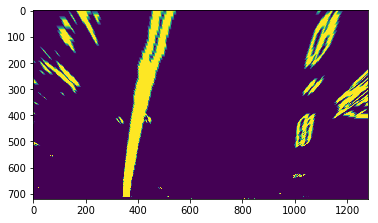

1048 m 548 m
798 m
Vehicule is  0.28 m right of line center


In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension


# Compute curvature
def get_curvature_real(binary_warped, y_eval, left_fit, right_fit):

    # Re-generate lanes points for real world measurements
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit polynomial in real world (factor m/pixel info)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Compute curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    return left_curverad, right_curverad


# Compute offset
def get_offset(binary_warped, y_eval, left_fit, right_fit):
    # Find center of the lane
    xLeft_pix = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    xRight_pix = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    xLaneCenter_pix = (xLeft_pix + xRight_pix) / 2
    
    # Find center of image
    xImgCenter_pix = (binary_warped.shape[1] / 2)
    
    # Compare to center of image
    offset_m = (xImgCenter_pix - xLaneCenter_pix) * xm_per_pix
    
    return offset_m
    
'''
Calculates the curvature of polynomial functions in meters.
'''
def measure_curvature_real(binary_warped, y_eval):  
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Compute offset
    # Find center of the lane
    xLeft_pix = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    xRight_pix = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
    xLaneCenter_pix = (xLeft_pix + xRight_pix) / 2
    
    # Find center of image
    xImgCenter_pix = (binary_warped.shape[1] / 2)
    
    # Compare to center of image
    offset_m = (xImgCenter_pix - xLaneCenter_pix) * xm_per_pix
    
    #print('lane center :', xLaneCenter_pix)
    #print('image center :', xImgCenter_pix)
    
    
    return left_curverad, right_curverad, offset_m


# Calculate the radius of curvature in meters for both lane lines
# Load our image
binary_warped = cv2.imread('output_images/Step4_warped_thresholded_test6.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(binary_warped)
plt.show()
y_eval = 700
left_curverad, right_curverad, offset_yBot = measure_curvature_real(binary_warped, y_eval)

print(np.int32(left_curverad), 'm', np.int32(right_curverad), 'm')
avg_curverad = np.int32((left_curverad + right_curverad) / 2)
print(avg_curverad, 'm')

if (offset_yBot < 0):
    print('Vehicule is ', np.around(np.absolute(offset_yBot), decimals=2), 'm right of line center')
else:
    print('Vehicule is ', np.around(np.absolute(offset_yBot), decimals=2), 'm left of line center')
    





### 7. Warp the detected lane boundaries back onto the original image.

In [8]:
# Test images
#undist = cv2.imread('output_images/Step2_undistorted_test6.png')
#warped = cv2.imread('output_images/Step4_warped_thresholded_test6.png', cv2.IMREAD_GRAYSCALE)

# Helper function for visualization
def lane_visualization(undist, warped, left_fit, right_fit):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


# Lane fitting with visualization (on original undistorted image)
def lane_fittingWithVisualization(undist, warped):
    

    # Find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)
    
    # Fit with a polynomial
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Visualize lane
    result = lane_visualization(undist, warped, left_fit, right_fit)
    return result

def add_curvatureOffset(result, warped, left_curverad, right_curverad, offset_yBot):
    avg_curverad = np.int32((left_curverad + right_curverad) / 2) 
    curv_txt = 'Curvature is '+ str(avg_curverad) +'m'
    if (offset_yBot < 0):
        offset_txt = 'Vehicule is ' + str(np.around(np.absolute(offset_yBot), decimals=2)) + 'm right of lane center'
    else:
        offset_txt = 'Vehicule is ' + str(np.around(np.absolute(offset_yBot), decimals=2)) + 'm left of lane center'

    cv2.putText(result, curv_txt, (400,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA)
    cv2.putText(result, offset_txt, (400,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), lineType=cv2.LINE_AA)


    
# Detect line from warped test images
# List of test images
curved_lines_undist = glob.glob('output_images/Step2_undistorted_test*.png')
straight_lines_undist = glob.glob('output_images/Step2_undistorted_straight_lines*.png')
undist_images = straight_lines_undist + curved_lines_undist

curved_lines_warped = glob.glob('output_images/Step4_warped_thresholded_test*.png')
straight_lines_warped = glob.glob('output_images/Step4_warped_thresholded_straight_lines*.png')
warped_images = straight_lines_warped + curved_lines_warped

images_tuple = np.transpose([undist_images, warped_images])

for [u, w] in images_tuple:
    undist = cv2.imread(u)
    warped = cv2.imread(w, cv2.IMREAD_GRAYSCALE)

    # Draw lane boundaries on original image
    result = lane_fittingWithVisualization(undist, warped)
    
    # Measure and add curvature and offset info to image
    y_eval = 700
    left_curverad, right_curverad, offset_yBot = measure_curvature_real(warped, y_eval)
    add_curvatureOffset(result, warped, left_curverad, right_curverad, offset_yBot)
    
    if (disp):
        cv2.imshow('result', result)
        cv2.waitKey(500)
    
    res_name = 'result_'+u[20:-4]+'.png'
    #print(out_name)
    cv2.imwrite('output_images/Step67_'+res_name, result)

cv2.destroyAllWindows()

## Now, build image pipeline and test it on a video
Build the pipeline to process a single image. Goal is to draw lane boundaries on the image.

In [9]:
def process_image(image):
    
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Color thresholding
    hls_binary = hls_select(undist, thresh=(90, 255))
    
    # Gradient thresholding on gray image
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    grad_binary = np.zeros_like(dir_binary)
    grad_binary[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1  
    
    # Combine gradient and color thresholds
    comb_binary = np.zeros_like(dir_binary)
    comb_binary[(hls_binary == 1) | (grad_binary == 1)] = 255
        
    # Perspective transform to prepare for line fitting
    warped = cv2.warpPerspective(comb_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Lane fitting and visualization on undistorted image
    result = lane_fittingWithVisualization(undist, warped)
       
    # Measure and add curvature and offset info to image
    y_eval = 700
    left_curverad, right_curverad, offset_yBot = measure_curvature_real(warped, y_eval)
    add_curvatureOffset(result, warped, left_curverad, right_curverad, offset_yBot)
    
    # Return undistorted original image, with lane finding info and visualization
    return result




# Define a class to receive the characteristics of each line detection
class LineHist():
    def __init__(self, histSize):        
        # Reset history?
        self.reset = True
        # History size
        self.n = histSize
        # Track valid info in history
        self.valids = np.zeros(self.n).astype(bool) 

        # Curvature history
        self.curvs = np.zeros(self.n)
        # Curvature history average
        self.curv_avg = -1 # invalid init
        
        # Polynomial coefficient history
        self.polys = np.zeros((self.n,3))
        # Polynomial coefficient average
        self.poly_avg = [0, 0, 0]
    
    def compute_curv_avg(self):
        curv_avg = -1 # invalid by default
        vld_curv = []
        for i in range(self.n):
            if (self.valids[i]):
                vld_curv.append(self.curvs[i])
                
        if (self.reset != True):
            curv_avg = np.sum(vld_curv)/len(vld_curv)    
        return curv_avg
        
    def compute_poly_avg(self):
        poly_avg = [0, 0, 0]
        vld_polys = []
        for i in range(self.n):
            if (self.valids[i]):
                vld_polys.append(self.polys[i,:])
  
        if (self.reset != True):
            poly_avg = np.array((np.matrix(vld_polys)).mean(0))
            poly_avg = poly_avg.reshape(3)
        return poly_avg
    
    def get_poly(self):
        return self.poly_avg
    
    def get_curvature(self):
        return self.curv_avg
    
    def update_hist(self, new_valid, new_curv, new_poly):
        # update valids
        self.valids[:-1] = self.valids[1:]
        self.valids[-1] = new_valid
        
        # signal no valid history
        if (all(vld == False for vld in self.valids)):
            self.reset = True
        else:
            self.reset = False
        
        # update curvatures
        self.curvs[:-1] = self.curvs[1:]
        self.curvs[-1] = -1
        if (new_valid):
            self.curvs[-1] = new_curv
            
        # update polynomials
        self.polys[:-1,:] = self.polys[1:,:]
        self.polys[-1,:] = [0, 0, 0]
        if (new_valid):
            self.polys[-1,:] = new_poly
        
        # set averages
        self.curv_avg = self.compute_curv_avg()
        self.poly_avg = self.compute_poly_avg()
            
    def print_me(self):
        print('LineHist: valids=',self.valids, 'curvs=', self.curvs, 'curv_avg=', self.curv_avg)
        print('polys=',self.polys)
        print('ploy_avg=', self.poly_avg)
            
#test_lineHist = LineHist(5)
#test_lineHist.print_me()
#test_lineHist.update_hist(True, 100, [1,1,1])
#test_lineHist.update_hist(True, 200, [2,2,2])
#test_lineHist.update_hist(True, 300, [3,3,3])
#test_lineHist.update_hist(True, 400, [4,4,4])
#test_lineHist.update_hist(False, 500, [5,5,5])
#test_lineHist.update_hist(True, 600, [6,6,6])
#test_lineHist.print_me()

left_lines = LineHist(45)
right_lines = LineHist(45)


def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    ### Fit a second order polynomial to each with np.polyfit() ###
    try:
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        #print('The function failed to fit a line!')
        left_fit_new = [0,0,binary_warped.shape[1]//4]
        right_fit_new = [0,0,binary_warped.shape[1]//4*3]
    
    return left_fit_new, right_fit_new


def poly_eval(p, y):
    x = (p[0] * (y ** 2)) + (p[1] * y) + p[2]
    return x

def seemsParallel(left_fit, right_fit, y_bot, y_mid):
    x_left0  = poly_eval(left_fit , y_bot)
    x_right0 = poly_eval(right_fit, y_bot)
    x_left1  = poly_eval(left_fit , y_mid)
    x_right1 = poly_eval(right_fit, y_mid)
    
    dist0 = x_right0 - x_left0
    dist1 = x_right1 - x_left1
    
    dist_ratio = dist1/dist0
    
    if ((dist_ratio < 0.7) or (dist_ratio > 1.3)):
        seemsP = False
    else:
        seemsP = True
    
    return seemsP


def process2_image(image):
    
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Color thresholding
    hls_binary = hls_select(undist, thresh=(90, 255))
    
    # Gradient thresholding on gray image
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))
    grad_binary = np.zeros_like(dir_binary)
    grad_binary[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1  
    
    # Combine gradient and color thresholds
    comb_binary = np.zeros_like(dir_binary)
    comb_binary[(hls_binary == 1) | (grad_binary == 1)] = 255
        
    # Perspective transform to prepare for line fitting
    warped = cv2.warpPerspective(comb_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Find lane pixels
    #    no previous detection
    if (left_lines.reset | right_lines.reset):
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

        # Fit a second order polynomial
        left_fit_tmp = np.polyfit(lefty, leftx, 2)
        right_fit_tmp = np.polyfit(righty, rightx, 2)
    
    #   around previous lane detection
    else:
        left_fit_tmp, right_fit_tmp = search_around_poly(warped, left_lines.get_poly(), right_lines.get_poly())
    
    # Measure curvatures
    y_eval = 700
    left_curverad_tmp, right_curverad_tmp = get_curvature_real(warped, y_eval, left_fit_tmp, right_fit_tmp)
    
    # Sanity check
    detection_valid = seemsParallel(left_fit_tmp, right_fit_tmp, y_eval, y_eval/2)
    
    # Smooth lane detection over short history
    left_lines.update_hist(detection_valid, left_curverad_tmp, left_fit_tmp)
    right_lines.update_hist(detection_valid, right_curverad_tmp, right_fit_tmp)
    
    left_fit = left_lines.get_poly()
    left_curvature = left_lines.get_curvature()
    right_fit = right_lines.get_poly()
    right_curvature = right_lines.get_curvature()
    
    # Visualize lane
    result = lane_visualization(undist, warped, left_fit, right_fit)
    
    # Add curvature and offset info
    # TODO: average offset        
    # Compute offset
    offset_m = get_offset(warped, y_eval, left_fit, right_fit)
    add_curvatureOffset(result, warped, left_curvature, right_curvature, offset_m)
    
    return result


Try on video

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

proj_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process2_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:44<00:00,  3.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 45s


In [11]:
proj_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
proj_clip = clip1.fl_image(process2_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [02:29<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 2min 30s


In [13]:
proj_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("harder_challenge_video.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
proj_clip = clip1.fl_image(process2_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [07:02<00:00,  3.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 7min 3s
